# <center><b>Data Mining Notebook: Salary Classification for Data Science Jobs</b></center>

## Import statements

In [350]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report,confusion_matrix
from xgboost import XGBClassifier

## Load the Dataset 

In [352]:
df = pd.read_csv('jobs_in_data.csv')
df.head()

,work_year,job_title,job_category,salary_currency,salary,salary_in_usd,employee_residence,experience_level,employment_type,work_setting,company_location,company_size
0,2023,Data DevOps Engineer,Data Engineering,EUR,88000,95012,Germany,Mid-level,Full-time,Hybrid,Germany,L
1,2023,Data Architect,Data Architecture and Modeling,USD,186000,186000,United States,Senior,Full-time,In-person,United States,M
2,2023,Data Architect,Data Architecture and Modeling,USD,81800,81800,United States,Senior,Full-time,In-person,United States,M
3,2023,Data Scientist,Data Science and Research,USD,212000,212000,United States,Senior,Full-time,In-person,United States,M
4,2023,Data Scientist,Data Science and Research,USD,93300,93300,United States,Senior,Full-time,In-person,United States,M


## Clean and Prepare the Data

In [354]:
df.drop(columns=['salary_currency','salary','work_year'],inplace=True)

df.isnull().sum()

job_title             0
job_category          0
salary_in_usd         0
employee_residence    0
experience_level      0
employment_type       0
work_setting          0
company_location      0
company_size          0
dtype: int64

## Creating Tiers for Salary, needed for Classification

In [356]:
def salary_category(salary):
    if salary < 100000:
        return 'Low'
    elif salary < 200000:
        return 'Medium'
    else:
        return 'High'

In [357]:
df['salary_class'] = df['salary_in_usd'].apply(salary_category)
print(df['salary_class'].value_counts())
print(df.columns)

salary_class
Medium    5462
High      1954
Low       1939
Name: count, dtype: int64
Index(['job_title', 'job_category', 'salary_in_usd', 'employee_residence',
       'experience_level', 'employment_type', 'work_setting',
       'company_location', 'company_size', 'salary_class'],
      dtype='object')


## Encode Variables

In [359]:
label_cols = ['experience_level', 'employment_type', 'work_setting', 'company_size']
le = LabelEncoder()
for col in label_cols:
    df[col] = le.fit_transform(df[col])

df = pd.get_dummies(df, columns=['job_title', 'job_category', 'employee_residence', 'company_location'], drop_first=True)


## Split the Data into features and target and encode Y

In [361]:
X = df.drop(columns=['salary_in_usd','salary_class'])
y = df['salary_class']

le_y = LabelEncoder()
y = le_y.fit_transform(y)

## EDA

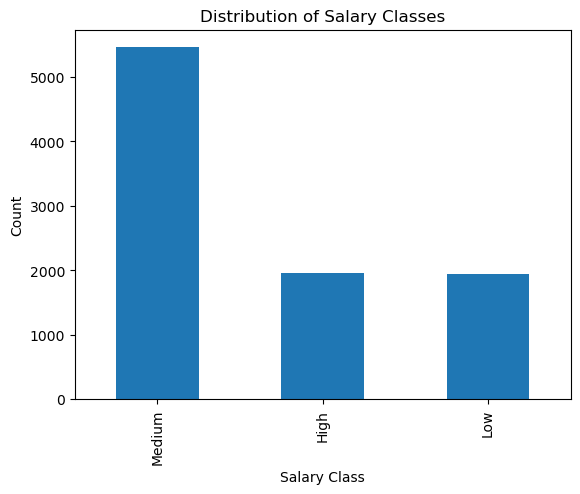

In [363]:
df['salary_class'].value_counts().plot(kind='bar', title='Distribution of Salary Classes')
plt.xlabel('Salary Class')
plt.ylabel('Count')
plt.show()

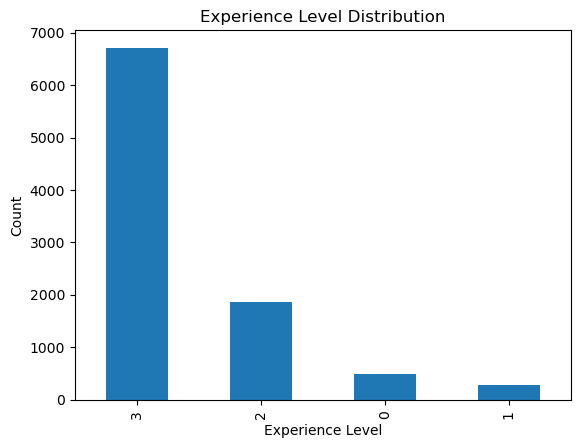

In [364]:
df['experience_level'].value_counts().plot(kind='bar', title='Experience Level Distribution')
plt.xlabel('Experience Level')
plt.ylabel('Count')
plt.show()

## Train Test Split

In [366]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42,stratify=y)

## Scale the features

In [368]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

## Train the XGBoost model

In [370]:
xgb = XGBClassifier(use_label_encoder=False, eval_metrics ='mlogloss',random_state=42)
xgb.fit(X_train,y_train)

/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [14:28:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "eval_metrics", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None,
              eval_metrics='mlogloss', feature_types=None, feature_weights=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None, ...)

## Evaluation of the model

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       391
           1       0.22      0.96      0.35       388
           2       0.59      0.08      0.14      1092

    accuracy                           0.25      1871
   macro avg       0.27      0.35      0.16      1871
weighted avg       0.39      0.25      0.16      1871



/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


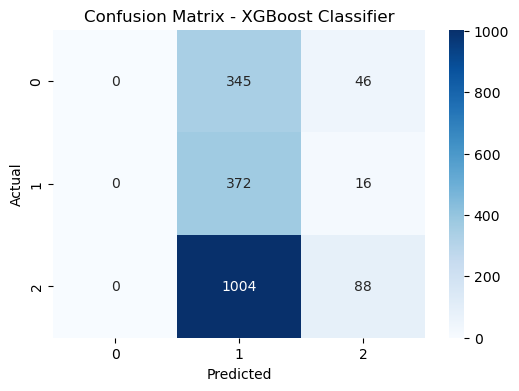

In [372]:
y_pred= xgb.predict(X_test)
print('Classification Report:')
print(classification_report(y_test,y_pred))

cm = confusion_matrix(y_test,y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=xgb.classes_, yticklabels=xgb.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - XGBoost Classifier")
plt.show()

In [373]:
print(pd.Series(y).value_counts())
print(df['salary_class'].value_counts())

2    5462
0    1954
1    1939
Name: count, dtype: int64
salary_class
Medium    5462
High      1954
Low       1939
Name: count, dtype: int64


## Random Forest Model, applying Balanced class weight and evaluation

In [375]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(class_weight='balanced',n_estimators=100,random_state=42)

rf.fit(X_train, y_train) 
y_pred = rf.predict(X_test)

print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.38      0.61      0.47       391
           1       0.53      0.72      0.61       388
           2       0.68      0.44      0.54      1092

    accuracy                           0.54      1871
   macro avg       0.53      0.59      0.54      1871
weighted avg       0.59      0.54      0.54      1871



## SVM model with evaluation 

In [377]:
from sklearn.svm import SVC

svm = SVC(kernel='linear', class_weight='balanced', random_state=42)

svm.fit(X_train, y_train)

y_pred_svm = svm.predict(X_test)

print("Support Vector Model:")
print(classification_report(y_test, y_pred_svm))


Support Vector Model:
              precision    recall  f1-score   support

           0       0.39      0.44      0.41       391
           1       0.50      0.70      0.58       388
           2       0.67      0.55      0.60      1092

    accuracy                           0.56      1871
   macro avg       0.52      0.56      0.53      1871
weighted avg       0.58      0.56      0.56      1871

